In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Feature Importance Analysis

In [10]:
def k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, sorted_feature_names): 
    regression_coefficients = []
    p_values = []
    rsf_weights = []
    for i in range(5):
        ### CPH feature importance
        fold_cph_file = "run_with_no_regularization/split" + str(i) + "/results/" + cph_file_name
        cph_table = pd.read_html(fold_cph_file)
        assert len(cph_table) == 1
        fold_cph_df = cph_table[0]
        fold_cph_df.rename(columns={"Unnamed: 0":"Feature"}, inplace=True)

        # Check that the feature order is the same for all folds
        fold_cph_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_cph_df["Feature"]) == sorted_feature_names

        regression_coefficients.append(fold_cph_df["coef"].to_numpy())
        p_values.append(fold_cph_df["p"].to_numpy())

        ### RSF feature importance
        fold_rsf_file = "run_with_no_regularization/split" + str(i) + "/results/" + rsf_file_name
        rsf_table = pd.read_html(fold_rsf_file)
        assert len(rsf_table) == 1
        fold_rsf_df = rsf_table[0]

        # Check that the feature order is the same for all folds
        fold_rsf_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_rsf_df["Feature"]) == sorted_feature_names

        fold_rsf_df[["Weight Avg", "Weight Std"]] = fold_rsf_df["Weight"].str.split("±", expand=True).astype("float")
        rsf_weights.append(fold_rsf_df["Weight Avg"])

    regression_coefficients = np.stack(regression_coefficients, axis=0)
    avg_coef = np.mean(regression_coefficients, axis=0)
    std_coef = np.std(regression_coefficients, axis=0)
    str_regression_coefficients = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_coef, std_coef)]

    p_values = np.stack(p_values, axis=0)
    avg_p = np.mean(p_values, axis = 0)
    std_p = np.std(p_values, axis = 0)
    str_p_values = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_p, std_p)]

    rsf_weights = np.stack(rsf_weights, axis=0)
    rsf_weight_avg_across_folds = np.mean(rsf_weights, axis=0)
    rsf_weight_std_across_folds = np.std(rsf_weights, axis=0)
    str_rsf_weights = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(rsf_weight_avg_across_folds, rsf_weight_std_across_folds)]

    k_fold_df = pd.DataFrame(data={"Feature": sorted_feature_names, "CPH coefficient": str_regression_coefficients, "CPH p-value": str_p_values, "RSF Importance Weight": str_rsf_weights})
    
    return k_fold_df, avg_coef, std_coef, avg_p, std_p, rsf_weight_avg_across_folds, rsf_weight_std_across_folds

## Clinical

In [11]:
clin_feature_names = [
        'Age',
        'BMI',
        'Pack-year',
        'Smoking-start-age',
        'Cigarettes-per-day',
        'Number-of-smoking-years',
        'High-school-graduate',
        'Post-HS-training',
        'Associate-degree',
        'Bachelors-degree',
        'Graduate-school',
        'Female',
        'Non-white',
        'Smoking-at-the-start-of-trial',
        'Lived-with-smoker',
        'Worked-with-smoker',
        'Cancer-prior-to-trial',
        'Family-member-had-cancer']

clin_feature_names.sort()

In [12]:
cph_file_name = "cph_clinical_all.html"
rsf_file_name = "rsf_clinical_all.html"

clinical_df, avg_coef, std_coef, avg_p, std_p, avg_rsf_weight, std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, clin_feature_names)
display(clinical_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,Age,-0.099 ± 0.031,0.649 ± 0.100,0.061 ± 0.017
1,Associate-degree,0.149 ± 0.265,0.665 ± 0.201,0.013 ± 0.006
2,BMI,0.056 ± 0.073,0.582 ± 0.224,0.094 ± 0.013
3,Bachelors-degree,-0.083 ± 0.277,0.673 ± 0.148,0.008 ± 0.006
4,Cancer-prior-to-trial,0.940 ± 0.185,0.041 ± 0.062,0.017 ± 0.010
5,Cigarettes-per-day,-0.402 ± 0.475,0.590 ± 0.216,0.035 ± 0.011
6,Family-member-had-cancer,0.246 ± 0.151,0.437 ± 0.300,0.016 ± 0.011
7,Female,-0.628 ± 0.201,0.085 ± 0.111,0.020 ± 0.004
8,Graduate-school,-0.178 ± 0.277,0.661 ± 0.200,0.003 ± 0.002
9,High-school-graduate,0.125 ± 0.277,0.691 ± 0.200,0.012 ± 0.005


In [13]:
def plot_metrics(mean_array, std_array, feature_names, ylabel, title, ax):
    sorted_idx = np.argsort(mean_array)

    feature_index = np.arange(len(feature_names))
    ax.bar(feature_index, mean_array[sorted_idx], yerr=std_array[sorted_idx], align='center', capsize=5)
    ax.set_xticks(feature_index)
    ax.set_xticklabels([feature_names[i] for i in sorted_idx], rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')
#     ax.rc('font', {'name': 'times'})

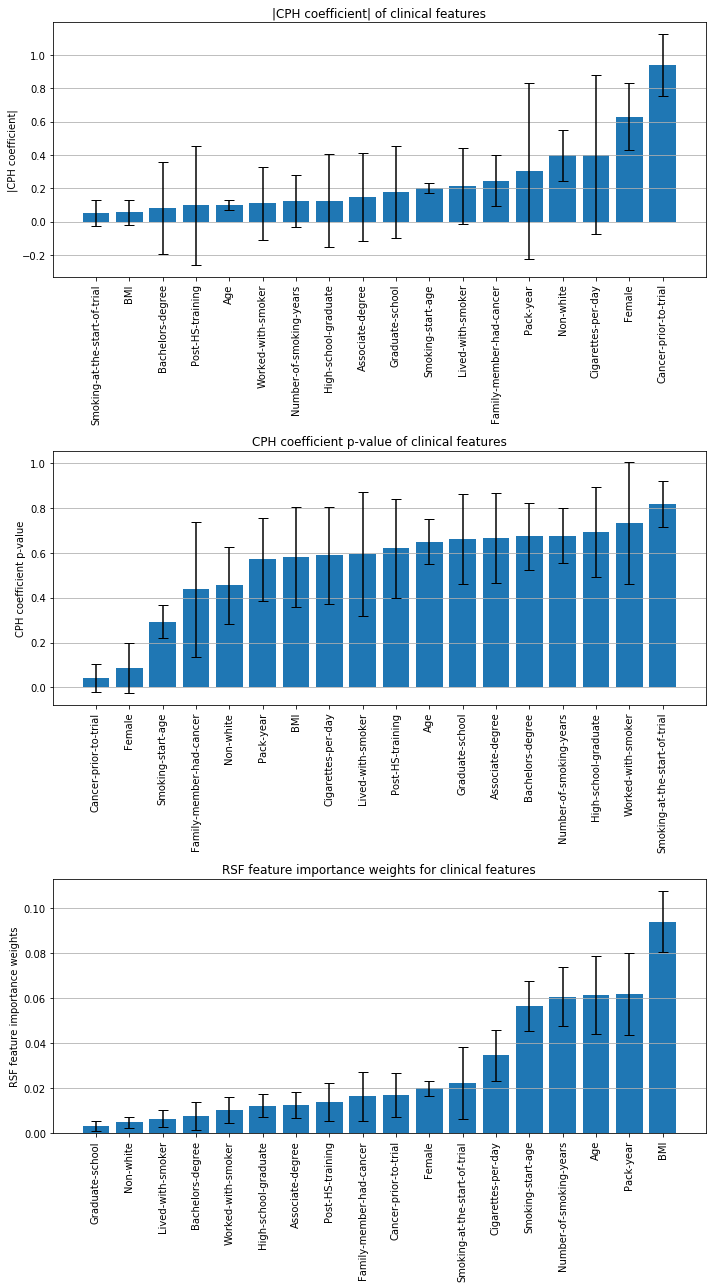

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10,18))

plot_metrics(np.absolute(avg_coef), std_coef, clin_feature_names, '|CPH coefficient|','|CPH coefficient| of clinical features', axes[0])
plot_metrics(avg_p, std_p, clin_feature_names, 'CPH coefficient p-value','CPH coefficient p-value of clinical features', axes[1])
plot_metrics(avg_rsf_weight, std_rsf_weight, clin_feature_names, 'RSF feature importance weights','RSF feature importance weights for clinical features', axes[2])

fig.tight_layout()

## Radiomics 1

In [15]:
radiomics1_feature_names = ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume']
radiomics1_feature_names.sort()

In [16]:
cph_file_name = "cph_radiomics1_all.html"
rsf_file_name = "rsf_radiomics1_all.html"

radiomics1_df, rad1_avg_coef, rad1_std_coef, rad1_avg_p, rad1_std_p, rad1_avg_rsf_weight, rad1_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics1_feature_names)
display(radiomics1_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_shape_Elongation,-0.760 ± 0.233,0.185 ± 0.126,0.017 ± 0.006
1,original_shape_Flatness,0.459 ± 0.362,0.483 ± 0.345,0.024 ± 0.015
2,original_shape_LeastAxisLength,-0.655 ± 1.011,0.538 ± 0.341,0.019 ± 0.013
3,original_shape_MajorAxisLength,-1.451 ± 0.785,0.289 ± 0.272,0.029 ± 0.015
4,original_shape_Maximum2DDiameterColumn,0.683 ± 0.335,0.399 ± 0.224,0.021 ± 0.020
5,original_shape_Maximum2DDiameterRow,-0.445 ± 0.617,0.521 ± 0.345,0.021 ± 0.025
6,original_shape_Maximum2DDiameterSlice,-0.725 ± 0.260,0.330 ± 0.151,0.016 ± 0.025
7,original_shape_Maximum3DDiameter,1.058 ± 1.225,0.351 ± 0.180,0.018 ± 0.030
8,original_shape_MinorAxisLength,1.714 ± 0.627,0.331 ± 0.156,0.019 ± 0.014
9,original_shape_Sphericity,0.279 ± 0.165,0.320 ± 0.338,0.048 ± 0.025


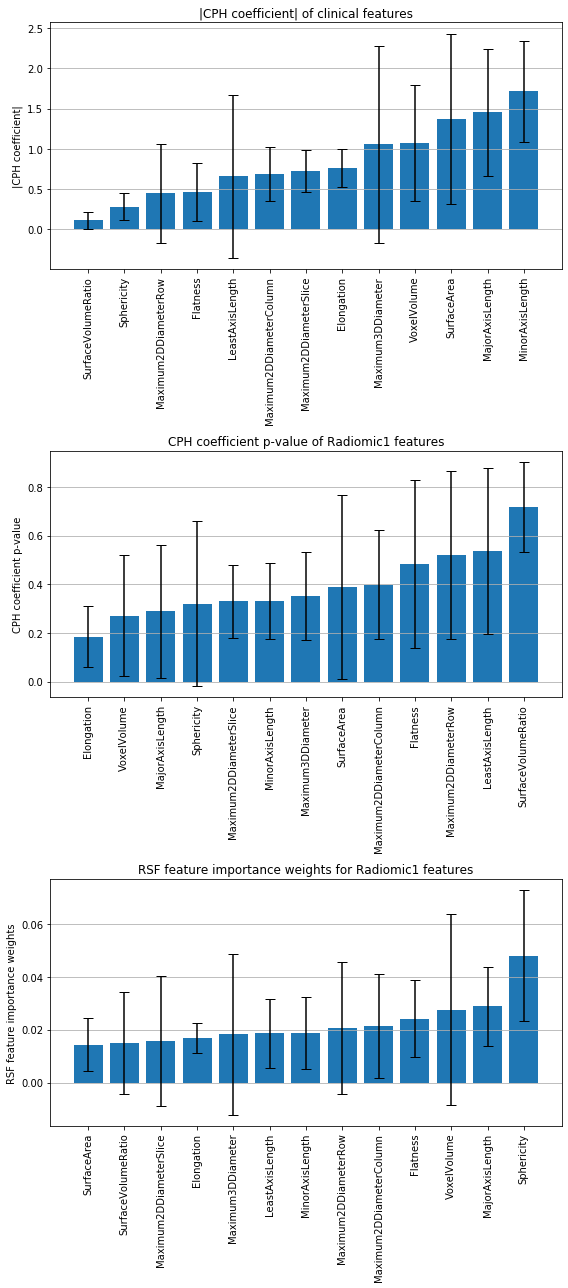

In [17]:
rad1_feature_names_cleaned = [name.replace('original_shape_', '') for name in radiomics1_feature_names]
fig, axes = plt.subplots(3, 1, figsize=(8,18))

plot_metrics(np.absolute(rad1_avg_coef), rad1_std_coef, rad1_feature_names_cleaned, '|CPH coefficient|','|CPH coefficient| of clinical features', axes[0])
plot_metrics(rad1_avg_p, rad1_std_p, rad1_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of Radiomic1 features', axes[1])
plot_metrics(rad1_avg_rsf_weight, rad1_std_rsf_weight, rad1_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for Radiomic1 features', axes[2])

fig.tight_layout()

## Radiomics 2

In [18]:
radiomics2_feature_names = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance']
radiomics2_feature_names.sort()

In [19]:
cph_file_name = "cph_radiomics2_all.html"
rsf_file_name = "rsf_radiomics2_all.html"

radiomics2_df, rad2_avg_coef, rad2_std_coef, rad2_avg_p, rad2_std_p, rad2_avg_rsf_weight, rad2_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics2_feature_names)
display(radiomics2_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_firstorder_10Percentile,-0.966 ± 0.414,0.374 ± 0.184,0.018 ± 0.010
1,original_firstorder_90Percentile,2.633 ± 0.575,0.069 ± 0.066,0.009 ± 0.008
2,original_firstorder_Energy,0.528 ± 0.215,0.105 ± 0.123,0.018 ± 0.004
3,original_firstorder_Entropy,-0.845 ± 0.451,0.354 ± 0.236,0.011 ± 0.006
4,original_firstorder_InterquartileRange,0.291 ± 0.145,0.510 ± 0.212,0.018 ± 0.023
5,original_firstorder_Kurtosis,-0.287 ± 0.460,0.365 ± 0.213,0.018 ± 0.004
6,original_firstorder_Maximum,0.148 ± 0.087,0.563 ± 0.229,0.027 ± 0.007
7,original_firstorder_Median,0.301 ± 0.278,0.794 ± 0.175,0.023 ± 0.009
8,original_firstorder_Minimum,0.062 ± 0.165,0.628 ± 0.247,0.014 ± 0.016
9,original_firstorder_RootMeanSquared,1.428 ± 0.953,0.579 ± 0.239,0.017 ± 0.019


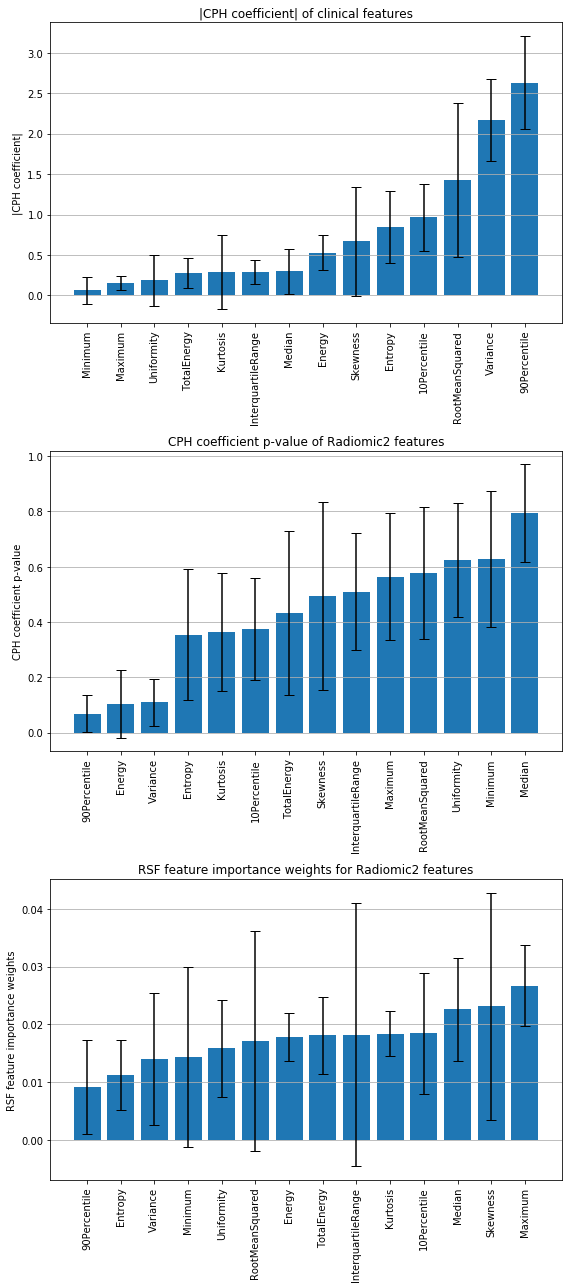

In [20]:
rad2_feature_names_cleaned = [name.replace('original_firstorder_', '') for name in radiomics2_feature_names]
fig, axes = plt.subplots(3, 1, figsize=(8,18))

plot_metrics(np.absolute(rad2_avg_coef), rad2_std_coef, rad2_feature_names_cleaned, '|CPH coefficient|','|CPH coefficient| of clinical features', axes[0])
plot_metrics(rad2_avg_p, rad2_std_p, rad2_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of Radiomic2 features', axes[1])
plot_metrics(rad2_avg_rsf_weight, rad2_std_rsf_weight, rad2_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for Radiomic2 features', axes[2])

fig.tight_layout()

# Average C-index and MTD-AUC

In [21]:
c_index_by_fold = []
mtd_auc_by_fold = []
for i in range(5):
    result_file = "split" + str(i) + "/results.txt"
    results_df = pd.read_csv(result_file, sep='\t', header=None, names=["Experiment name", "C-index", "MTD-AUC"])
    
    c_index_by_fold.append(results_df["C-index"].to_numpy())
    mtd_auc_by_fold.append(results_df["MTD-AUC"].to_numpy())
    
c_index = np.stack(c_index_by_fold, axis=0)
avg_c_index = np.mean(c_index, axis=0)
std_c_index = np.std(c_index, axis=0)
str_c_index = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_c_index, std_c_index)]

mtd_auc = np.stack(mtd_auc_by_fold, axis=0)
avg_mtd_auc = np.mean(mtd_auc, axis=0)
std_mtd_auc = np.std(mtd_auc, axis=0)
str_mtd_auc = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_mtd_auc, std_mtd_auc)]

k_fold_results_df = pd.DataFrame(data={"Experiment name": results_df["Experiment name"].to_numpy(), "C-index": str_c_index, "MTD-AUC": str_mtd_auc})
k_fold_results_df[["Model", "Data", "Subset"]] = k_fold_results_df["Experiment name"].str.split("-", expand=True)
k_fold_results_df.drop(columns='Subset', inplace=True)
k_fold_results_df.replace("CPH_lifelines", "CPH", inplace=True)
display(k_fold_results_df)

FileNotFoundError: [Errno 2] File b'split1/results.txt' does not exist: b'split1/results.txt'

# TD-AUC Curve

In [ ]:
cph_auc_file = "clinical_all_cpc_auc.npy"
rsf_auc_file = "clinical_all_rsf_auc.npy"
va_times_file = "clinical_all_va_times.npy"

cph_auc_by_split = []
rsf_auc_by_split = []
va_times_by_split = []

max_start = 0
min_end = np.inf
for i in range(4):
    cph_auc_by_split.append(np.load("old_fold_runs/split" + str(i) + "/" + cph_auc_file))
    rsf_auc_by_split.append(np.load("old_fold_runs/split" + str(i) + "/" + rsf_auc_file))
    va_times = np.load("old_fold_runs/split" + str(i) + "/" + va_times_file)
    va_times_by_split.append(va_times)
    if va_times[0] > max_start: 
        max_start = va_times[0]
    if va_times[-1] < min_end:
        min_end = va_times[-1]

cph_auc_pruned = []
rsf_auc_pruned = []
for va_times, cph_auc, rsf_auc in zip(va_times_by_split, cph_auc_by_split, rsf_auc_by_split):
    start_idx = np.where(va_times == max_start)[0][0]
    end_idx = np.where(va_times == min_end)[0][0]
    cph_auc_pruned.append(cph_auc[start_idx:end_idx])
    rsf_auc_pruned.append(rsf_auc[start_idx:end_idx])
    
    
cph_auc_matrix = np.stack(cph_auc_pruned, axis=0)
cph_auc_mean = np.mean(cph_auc_matrix, axis=0)
cph_auc_std = np.std(cph_auc_matrix, axis=0)

rsf_auc_matrix = np.stack(rsf_auc_pruned, axis=0)
rsf_auc_mean = np.mean(rsf_auc_matrix, axis=0)
rsf_auc_std = np.std(rsf_auc_matrix, axis=0)

times = np.arange(max_start, min_end)

In [ ]:
times = times[::30]
cph_auc_mean = cph_auc_mean[::30]
cph_auc_std = cph_auc_std[::30]
rsf_auc_mean = rsf_auc_mean[::30]
rsf_auc_std = rsf_auc_std[::30]

In [ ]:
plt.ylim(0.0,1.0)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(np.arange(0.0, 1, step=0.1))  # Set label locations.
plt.plot(times, cph_auc_mean, "-", label="CoxPH", color="b")
plt.fill_between(times, cph_auc_mean - cph_auc_std, cph_auc_mean + cph_auc_std, color='b', alpha=0.2)
plt.plot(times, rsf_auc_mean, "-", label="RSF", color="orange")
plt.fill_between(times, rsf_auc_mean - rsf_auc_std, rsf_auc_mean + rsf_auc_std, color='orange', alpha=0.2)
plt.xlabel("Days from enrollment")
plt.ylabel("AUC")
plt.title("Time-dependent AUC")
plt.legend(loc="lower center")
plt.grid()